In [1]:
%pylab inline
import os
import pickle
import warnings
import pandas as pd
from astropy.wcs import WCS
import katalogss.fhd_pype as fp
import katalogss.katalogss as kg

warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


The first part of this tutorial shows you how to get the data you need from the FHD output directories. This relies mostly on functions in the fhd_pype module. 

The function `fp.fhd_base()` returns the full path to the directory where the FHD output is located. It defaults to the common Aug23 output folder on the MIT cluster, but this can be assigned to another string using `fp.set_fhd_base(<new_path>)`.

In [2]:
print 'The default path: '+fp.fhd_base()
fp.set_fhd_base(os.getcwd().strip('scripts')+'katalogss/data')
print 'Our path: '+fp.fhd_base()


The default path: /nfs/eor-09/r1/djc/EoR2013/Aug23/
Our path: /astro/users/pcarroll/MWA/katalogss/katalogss/data/


We also need to define the version specifying the name of the run. This is equivalent to the case string in eor\_firstpass\_versions.pro, or the string following "fhd\_" in the output directory name. 

The katalogss data directory includes a mock FHD output run and the relevant files for a single obsid. 

In [3]:
fhd_run = 'mock_run'
s = '%sfhd_%s'%(fp.fhd_base(),fhd_run)
!ls -R $s

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run:
deconvolution  katalogss  katalogss_old  metadata  output_data

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run/deconvolution:
1066580664_fhd_params.sav  1066580664_fhd.sav

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run/katalogss:
area_maps  components.p

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run/katalogss/area_maps:
1066580664_amap.fits

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run/katalogss_old:
area_maps  catalogs.p  components.p

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run/katalogss_old/area_maps:
1061316296_amap.fits

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run/metadata:
0:  1066580664_obs.sav

/astro/users/pcarroll/MWA/katalogss/katalogss/data/fhd_mock_run/output_data:
1066580664_Beam_XX.fits  1066580664_uniform_Residual_I.fits
1066580664_Beam_YY.fits


Next we want to define the list of obsids we want to process. You can do this manually, or you can easily grab all obsids with deconvolution output for your run using:

In [4]:
obsids = fp.get_obslist(fhd_run)
obsids

['1066580664']

Next we'll grab the source components and metadata for each obsid in the list. Note that if you don't supply the list of obsids, it will automatically run for all obsids. 

In [5]:
comps  = fp.fetch_comps(fhd_run, obsids=obsids)
meta = fp.fetch_meta(fhd_run,obsids=obsids)

Fetching compoonent array from 1066580664_fhd.sav


This returns a dictionary of dictionaries. Since it takes some work to run, let's cache it a new katalogss output directory.

In [8]:
kgs_out = '%sfhd_%s/katalogss/'%(fp.fhd_base(),fhd_run)
if not os.path.exists(kgs_out): os.mkdir(kgs_out)

print 'saving %scomponent_arrays.p'
pickle.dump([comps,meta], open(kgs_out+'components.p','w'))
comps

saving %scomponent_arrays.p


{'1066580664': {'alpha': array([-0.80000001, -0.80000001, -0.80000001, ..., -0.80000001,
         -0.80000001, -0.80000001]),
  'dec': array([-27.73212051, -28.1602993 , -27.73209   , ..., -29.28472519,
         -37.0483551 , -21.39456367]),
  'flag': array([ 0.,  0.,  0., ...,  2.,  0.,  0.]),
  'flux': array([ 2.02153563,  4.10171652,  1.82323956, ...,  0.01396699,
          0.02448948,  0.00976452]),
  'freq': array([ 182.43501282,  182.43501282,  182.43501282, ...,  182.43501282,
          182.43501282,  182.43501282]),
  'gain': array([ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1]),
  'id': array([  4.00000000e+00,   0.00000000e+00,   4.00000000e+00, ...,
           5.81100000e+03,  -1.00000000e+00,   2.53400000e+03]),
  'ra': array([ 57.91218948,  71.16273499,  57.91217804, ...,  66.2097702 ,
          55.21427155,  53.02481079]),
  'x': array([ 1536.05639648,  1833.78259277,  1536.05615234, ...,  1723.52001953,
          1465.60998535,  1412.20422363]),
  'y': array([ 1459.33105469, 

If you need to come back to this later, restore it with

`comps, meta = pickle.load(open(kgs_out+'component_arrays.p'))`

In [9]:
#comps, meta = pickle.load(open(kgs_out+'components.p'))

Now we want to get the beam and residual maps. These are stored in fits files, and we read them into HDU objects with `data` and `header` attributes. 

The `get_maps` function works for any of the 2D images stored as fits in the 'output\_data' directory. 

In [10]:
beamxx, beamyy, residual = [fp.get_maps(fhd_run, obsids=obsids, imtype=imtype)
                       for imtype in ('Beam_XX','Beam_YY','uniform_Residual_I')]

To convert the residual maps from Jy/pixel to Jy/beam, we need the map of pixel areas in units of beam.

In [11]:
pix2beam = fp.pixarea_maps(fhd_run, obsids=obsids, map_dir=kgs_out+'area_maps/')
for o in obsids: residual[o].data*=pix2beam[o]

Now we're ready to start source finding using the katalogss module. 

In [14]:
#clustering parameters
eps_factor = 0.25
min_samples = 1

catalog={}

for obsid in obsids:
    cmps = pd.DataFrame(comps[obsid])
    cmps = kg.clip_comps(cmps)

    beam = beamxx[obsid].copy()
    beam.data = np.sqrt(np.mean([beamxx[obsid].data**2, beamyy[obsid].data**2],axis=0))

    eps = eps_factor * meta[obsid]['beam_width']
    cmps = kg.cluster_sources(cmps, eps, min_samples)

    catalog[obsid] = kg.catalog_sources(cmps, meta[obsid], residual[obsid], beam)

In [15]:
cat = catalog[obsid]
cat.head(10)

,id,ncomp,ra,sig_ra,dec,sig_dec,flux,x,y,beam,sig_flux,ext
0,0,17,57.912690,0.001136,-27.731572,0.000908,20.607863,1537,1460,0.870620,0.015610,False
1,1,30,71.161941,0.002146,-28.160433,0.002305,43.623094,1835,1431,0.314305,0.037504,False
2,2,27,64.015560,0.000093,-20.938997,0.000322,14.716517,1686,1638,0.634651,0.020489,False
3,3,24,57.872148,0.001058,-14.488509,0.003805,23.169188,1527,1812,0.396126,0.030734,False
4,4,25,62.209217,0.000679,-24.302575,0.000061,10.277728,1641,1550,0.796489,0.016852,False
5,5,27,52.146617,0.000146,-28.697057,0.000396,10.571080,1399,1431,0.738417,0.017986,False
6,6,29,52.291740,0.000646,-26.004686,0.000107,8.043195,1400,1503,0.809474,0.016619,False
7,7,31,44.060973,0.000188,-23.414189,0.000175,19.685439,1186,1556,0.305076,0.038478,False
8,8,26,63.785760,0.001085,-29.482654,0.000842,10.288576,1670,1409,0.632137,0.020559,False
9,9,28,60.067256,0.000380,-16.167808,0.001243,13.205410,1586,1767,0.497452,0.025265,False


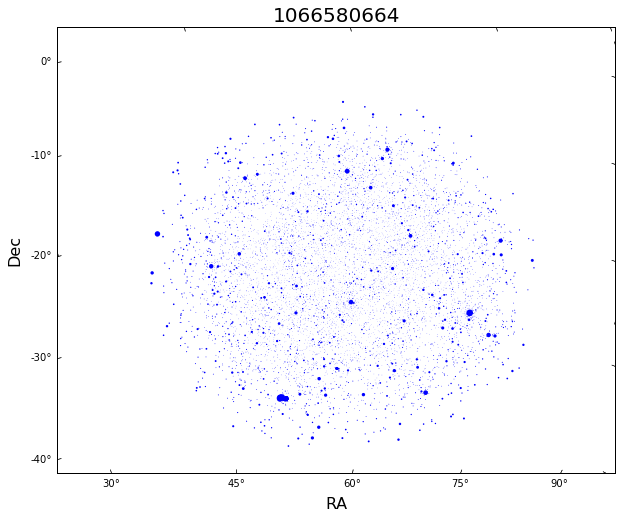

In [16]:
wcs = WCS(resi.header)
plt.figure(figsize=(10,8))
ax = plt.subplot(111,projection=wcs)
x,y = wcs.wcs_world2pix(cat.ra, cat.dec,1)
ax.scatter(x,y,s=cat.flux,edgecolor='none')
lon,lat = ax.coords
lon.set_axislabel('RA',fontsize=16)
lat.set_axislabel('Dec',fontsize=16)
ax.set_title(obsid,fontsize=20)

In [17]:
pickle.dump(catalog, open(kgs_out+'catalogs.p','w'))